## Requirements

In [0]:
!python3 -m pip install --upgrade nni
!pip install torchviz
!git clone -b v1.5 https://github.com/LIIXII/nni.git
!cd /content/nni/src/sdk/pynni;cp -r nni '/usr/local/lib/python3.6/dist-packages/'

## Define Search Space

In [0]:
import torch
import torch.nn as nn
from nni.nas.pytorch import mutables
from torchviz import make_dot
import torch.nn.functional as F
import json
import sys
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.pytorch import enas

In [0]:
class StdConv(nn.Module):
    def __init__(self, C_in, C_out):
        super(StdConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(C_in, C_out, 1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(C_out, affine=False),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)


class PoolBranch(nn.Module):
    def __init__(self, pool_type, C_in, C_out, kernel_size, stride, padding, affine=False):
        super().__init__()
        self.preproc = StdConv(C_in, C_out)
        self.pool = Pool(pool_type, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(C_out, affine=affine)

    def forward(self, x):
        out = self.preproc(x)
        out = self.pool(out)
        out = self.bn(out)
        return out


class SeparableConv(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding):
        super(SeparableConv, self).__init__()
        self.depthwise = nn.Conv2d(C_in, C_in, kernel_size=kernel_size, padding=padding, stride=stride,
                                   groups=C_in, bias=False)
        self.pointwise = nn.Conv2d(C_in, C_out, kernel_size=1, bias=False)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class ConvBranch(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride, padding, separable):
        super(ConvBranch, self).__init__()
        self.preproc = StdConv(C_in, C_out)
        if separable:
            self.conv = SeparableConv(C_out, C_out, kernel_size, stride, padding)
        else:
            self.conv = nn.Conv2d(C_out, C_out, kernel_size, stride=stride, padding=padding)
        self.postproc = nn.Sequential(
            nn.BatchNorm2d(C_out, affine=False),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.preproc(x)
        out = self.conv(out)
        out = self.postproc(out)
        return out


class FactorizedReduce(nn.Module):
    def __init__(self, C_in, C_out, affine=False):
        super().__init__()
        self.conv1 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False)
        self.conv2 = nn.Conv2d(C_in, C_out // 2, 1, stride=2, padding=0, bias=False)
        self.bn = nn.BatchNorm2d(C_out, affine=affine)

    def forward(self, x):
        out = torch.cat([self.conv1(x), self.conv2(x[:, :, 1:, 1:])], dim=1)
        out = self.bn(out)
        return out


class Pool(nn.Module):
    def __init__(self, pool_type, kernel_size, stride, padding):
        super().__init__()
        if pool_type.lower() == 'max':
            self.pool = nn.MaxPool2d(kernel_size, stride, padding)
        elif pool_type.lower() == 'avg':
            self.pool = nn.AvgPool2d(kernel_size, stride, padding, count_include_pad=False)
        else:
            raise ValueError()

    def forward(self, x):
        return self.pool(x)


class SepConvBN(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, padding):
        super().__init__()
        self.relu = nn.ReLU()
        self.conv = SeparableConv(C_in, C_out, kernel_size, 1, padding)
        self.bn = nn.BatchNorm2d(C_out, affine=True)

    def forward(self, x):
        x = self.relu(x)
        x = self.conv(x)


class ENASLayer(mutables.MutableScope):

    def __init__(self, key, prev_labels, in_filters, out_filters):
        super().__init__(key)
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.mutable = mutables.LayerChoice([
            ConvBranch(in_filters, out_filters, 3, 1, 1, separable=False),
            ConvBranch(in_filters, out_filters, 3, 1, 1, separable=True),
            ConvBranch(in_filters, out_filters, 5, 1, 2, separable=False),
            ConvBranch(in_filters, out_filters, 5, 1, 2, separable=True),
            PoolBranch('avg', in_filters, out_filters, 3, 1, 1),
            PoolBranch('max', in_filters, out_filters, 3, 1, 1)
        ])
        if len(prev_labels) > 0:
            self.skipconnect = mutables.InputChoice(choose_from=prev_labels, n_chosen=None)
        else:
            self.skipconnect = None
        self.batch_norm = nn.BatchNorm2d(out_filters, affine=False)

    def forward(self, prev_layers):
        out = self.mutable(prev_layers[-1])
        if self.skipconnect is not None:
            connection = self.skipconnect(prev_layers[:-1])
            if connection is not None:
                out += connection
        return self.batch_norm(out)


class GeneralNetwork(nn.Module):
    def __init__(self, num_layers=12, out_filters=24, in_channels=3, num_classes=10,
                 dropout_rate=0.0):
        super().__init__()
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.out_filters = out_filters

        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, out_filters, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_filters)
        )

        pool_distance = self.num_layers // 3
        self.pool_layers_idx = [pool_distance - 1, 2 * pool_distance - 1]
        self.dropout_rate = dropout_rate
        self.dropout = nn.Dropout(self.dropout_rate)

        self.layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()
        labels = []
        for layer_id in range(self.num_layers):
            labels.append("layer_{}".format(layer_id))
            if layer_id in self.pool_layers_idx:
                self.pool_layers.append(FactorizedReduce(self.out_filters, self.out_filters))
            self.layers.append(ENASLayer(labels[-1], labels[:-1], self.out_filters, self.out_filters))

        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dense = nn.Linear(self.out_filters, self.num_classes)

    def forward(self, x):
        bs = x.size(0)
        cur = self.stem(x)

        layers = [cur]

        for layer_id in range(self.num_layers):
            cur = self.layers[layer_id](layers)
            layers.append(cur)
            if layer_id in self.pool_layers_idx:
                for i, layer in enumerate(layers):
                    layers[i] = self.pool_layers[self.pool_layers_idx.index(layer_id)](layer)
                cur = layers[-1]

        cur = self.gap(cur).view(bs, -1)
        cur = self.dropout(cur)
        logits = self.dense(cur)
        return logits

## Visualization of json result

In [0]:
# Random Input
x=torch.randn(8,3,32,32)

# Search Space
model= GeneralNetwork()

#Enas mutator (more infomation about mutator class in nni doc)
mutator = enas.EnasMutator(model)

# Initiation 
mutator.reset()

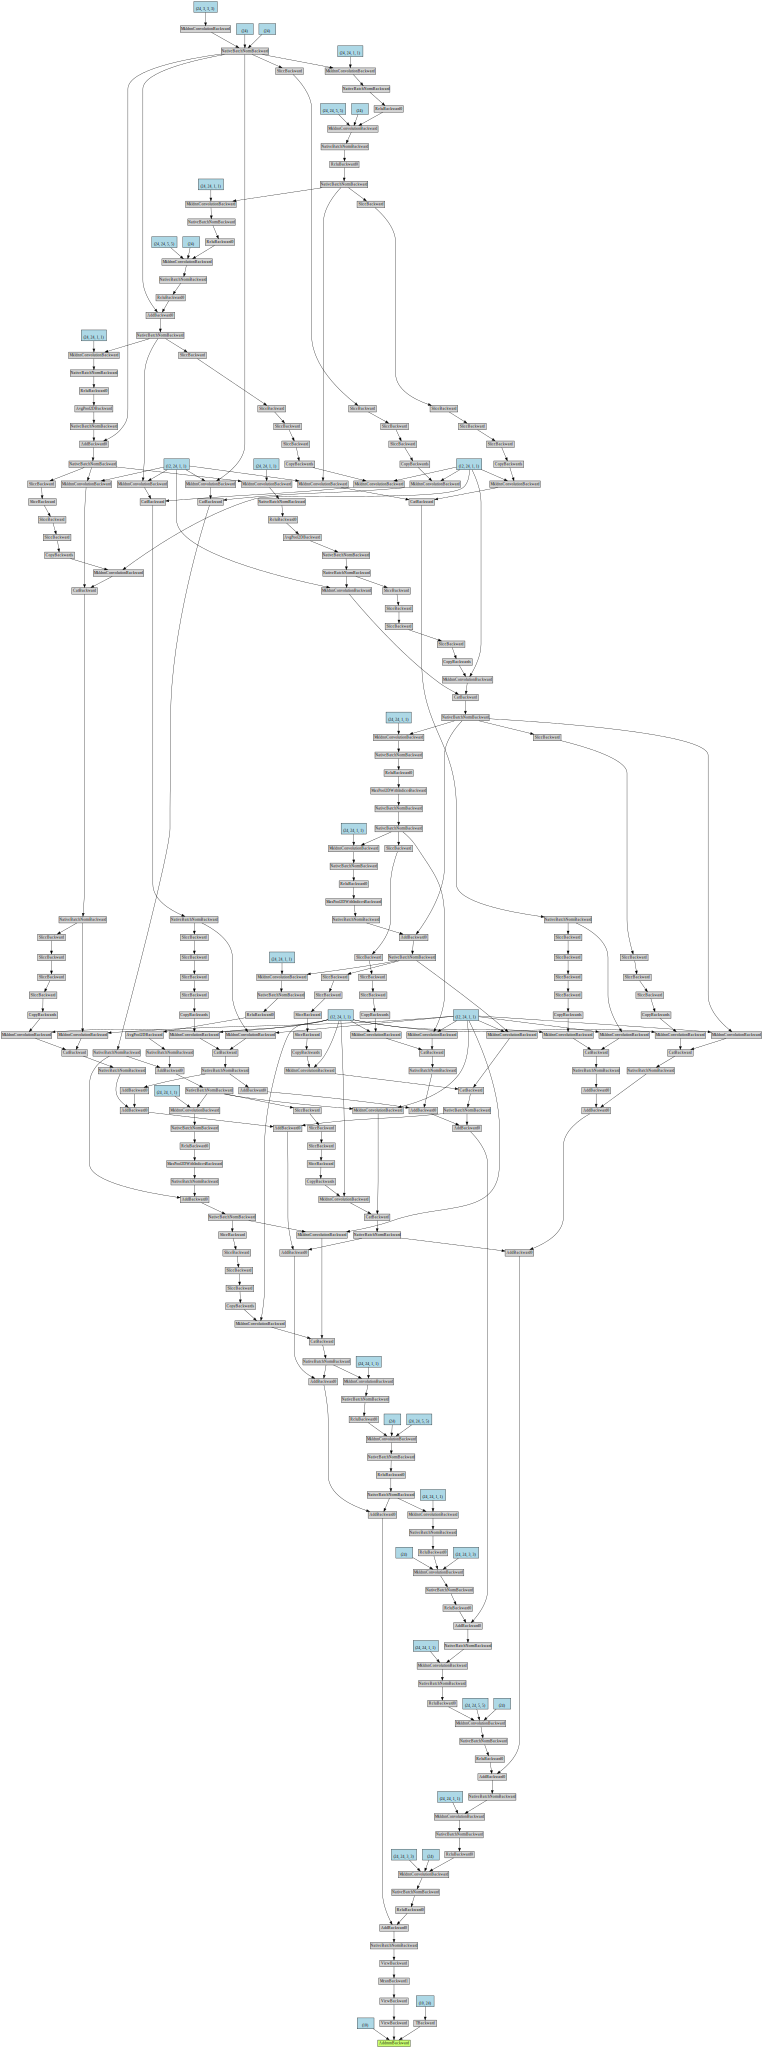

In [7]:
# Load json file (this is an exemple)
file = '/content/drive/My Drive/Colab Notebooks/Projet_fil_rouge/checkpoints/epoch_92.json'

# Import json file (make sure the json file use the same search space)
mutator.import_json(file)
y = model(x)

# Torchviz visualization
g = make_dot(y)
g